# **01 Data Generation**

This notebook shows how to use pretrained models to generate realistic, conditioned FTIR spectra.

In [2]:
# obligatory imports
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import joblib
import torch
import numpy as np
import contextlib
import io
import random
import pandas as pd
from sklearn.manifold import TSNE

from models.cbegan_lightning import SpectralCBEGAN
from models.cvae_lightning import LitVAE

from utils.utils import encode_labels

# Load data settings

In order to correctly use the trained models, we need to scale and encode new data according to our training procedure.

In [4]:
# Load data info, scalers and the categorical encoder
label_encoder = joblib.load("../pretrained_models/scalers/label_encoder.pkl")
minmax_scaler = joblib.load("../pretrained_models/scalers/minmax_scaler.pkl")
categorical_conditions = joblib.load("../pretrained_models/scalers/categorical_conditions.pkl")
continuous_conditions = joblib.load("../pretrained_models/scalers/continuous_conditions.pkl")
standard_scaler = joblib.load("../pretrained_models/scalers/std_scaler.pkl")

C:\Users\jung\anaconda3\envs\vae\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Load pretrained models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cbegan
cbegan = SpectralCBEGAN.load_from_checkpoint("../pretrained_models/weights_cbegan.ckpt", map_location=device)
cbegan.eval()

# cvae
checkpoint = torch.load(
    "../pretrained_models/weights_cvae.ckpt",
    weights_only=False,
    map_location=device
)

with contextlib.redirect_stdout(io.StringIO()):
    hparams = checkpoint['hyper_parameters']
    cvae = LitVAE(**hparams)
    cvae.load_state_dict(checkpoint['state_dict'])
    cvae.eval()

# Generate FTIR spectra

Lets start by creating a sample condition dict, representing a subject.

In [8]:
condition_dict = {
    "age": 38,
    "sex": "male",
    "bmi": 25
}

And define some helper functions, to encode conditions and to predict new spectra.

In [10]:
def batch_scale_and_encode_conditions(input_dicts, device):


    ordered_keys = list(input_dicts[0].keys())

    cont_df = pd.DataFrame(input_dicts, columns=continuous_conditions)
    scaled_cont_batch = minmax_scaler.transform(cont_df)

    batch_processed_values = []

    for i, input_dict in enumerate(input_dicts):
        processed_features = {}
        
        for col in categorical_conditions:
            if col in input_dict:
                processed_features[col] = label_encoder.transform([input_dict[col]])[0]
        
        for j, col in enumerate(continuous_conditions):
             if col in input_dict:
                processed_features[col] = scaled_cont_batch[i, j]

        ordered_values = [processed_features[key] for key in ordered_keys]
        batch_processed_values.append(ordered_values)

    combined_tensor = torch.tensor(np.array(batch_processed_values), dtype=torch.float32, device=device)

    label_dict = {}
    for i, col in enumerate(ordered_keys):
        label_dict[col] = combined_tensor[:, i].unsqueeze(1)

    return label_dict


def generate_spectra(model, conditions, N, latent_dim, embedding_dim, device):
    """ """
    if isinstance(conditions, dict):
        conditions = [conditions]
    noise = torch.randn(N, latent_dim).to(device)
    condition_dict = batch_scale_and_encode_conditions(conditions, device)
    encoded_conditions = encode_labels(condition_dict, embedding_dim, device=device)

    # 3. Generate spectra
    with torch.no_grad():
        if hasattr(model, "generator"):  # CBEGAN
            spectra = model.generator(noise, encoded_conditions)
        elif hasattr(model, "vae"):  # CVAE
            spectra = model.vae.decode(noise, condition_dict)
        else:
            raise ValueError("Model type not recognized.")

    return spectra.cpu().numpy()

Then we can predict:

In [12]:
spectrum_cbegan = generate_spectra(cbegan, condition_dict, 1, cbegan.noise_dim, embedding_dim=cbegan.pos_encoding_embedding_size, device=cbegan.device)
spectrum_cvae = generate_spectra(cvae, condition_dict, 1, cvae.vae.latent_dim, embedding_dim=cvae.vae.pos_encoding_embedding_dim, device=cvae.device)

In [13]:
# Inverse preproessing steps
spectrum_cbegan = standard_scaler.inverse_transform(spectrum_cbegan[0].reshape(1, -1))
spectrum_cvae = standard_scaler.inverse_transform(spectrum_cvae[0].reshape(1, -1))

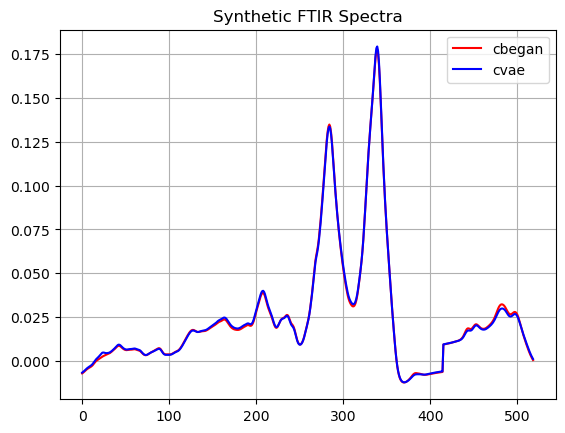

In [14]:
plt.figure()
plt.title("Synthetic FTIR Spectra")
plt.plot(spectrum_cbegan[0], color="red", label="cbegan")
plt.plot(spectrum_cvae[0], color="blue", label="cvae")
plt.grid()
plt.legend()
plt.show()

# Analyse condition effects

To analyse conditioning effects, we generate sample from two very distinct groups:

+ For the cbegan: young - women vs. old - men (bmi same)
+ For the cvae: women with low bmi vs. men with high bmi (age same)

And do a t-sne dimensionality reduction, to see if the two groups are distinguishable.

In [16]:
base_a_cbegan = {"age": 80, "sex": "male", "bmi": 27}
base_b_cbegan = {"age": 40, "sex": "female", "bmi": 27}

base_a_cvae = {"age": 50, "sex": "male", "bmi": 35}
base_b_cvae = {"age": 50, "sex": "female", "bmi": 20}

Add a function that creates slightly different subjects:

In [18]:
def generate_varied_inputs(base_input, num_samples, age_range=5, bmi_range=3):
    inputs = []
    for _ in range(num_samples):
        new_input = base_input.copy()
        # Add/subtract random offset to age and bmi
        new_input["age"] += random.randint(-age_range, age_range)
        new_input["bmi"] += random.uniform(-bmi_range, bmi_range)
        inputs.append(new_input)
    return inputs

Create different subjects and generate spectra:

In [20]:
N = 500

# Generate
spectra_a_cbegan = generate_spectra(
    model=cbegan,
    conditions=generate_varied_inputs(base_a_cbegan, N),
    N=N,
    latent_dim=cbegan.noise_dim,
    embedding_dim=cbegan.pos_encoding_embedding_size,
    device=cbegan.device
)

spectra_b_cbegan = generate_spectra(
    model=cbegan,
    conditions=generate_varied_inputs(base_b_cbegan, N),
    N=N,
    latent_dim=cbegan.noise_dim,
    embedding_dim=cbegan.pos_encoding_embedding_size,
    device=cbegan.device
)

spectra_a_cvae = generate_spectra(
    model=cvae,
    conditions=generate_varied_inputs(base_a_cvae, N),
    N=N,
    latent_dim=cvae.vae.latent_dim,
    embedding_dim=cvae.vae.pos_encoding_embedding_dim,
    device=cvae.device
)

spectra_b_cvae = generate_spectra(
    model=cvae,
    conditions=generate_varied_inputs(base_b_cvae, N),
    N=N,
    latent_dim=cvae.vae.latent_dim,
    embedding_dim=cvae.vae.pos_encoding_embedding_dim,
    device=cvae.device
)


And lastly, do a dimensionality reduction on the predictions and plot the result:

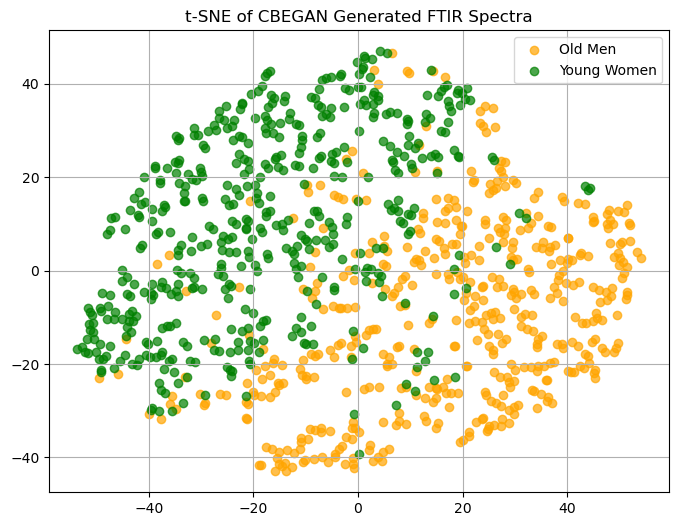

In [22]:
all_spectra_cbegan = np.vstack([spectra_a_cbegan, spectra_b_cbegan])
labels_cbegan = ["Young Women"] * N + ["Old Men"] * N

# t-SNE
tsne_cbegan = TSNE(n_components=2, perplexity=15, random_state=42)
embeddings_cbegan = tsne_cbegan.fit_transform(all_spectra_cbegan)

# Plot
plt.figure(figsize=(8, 6))
colors_cbegan = {"Young Women": "green", "Old Men": "orange"}
for label in set(labels_cbegan):
    idxs = [i for i, l in enumerate(labels_cbegan) if l == label]
    plt.scatter(embeddings_cbegan[idxs, 0], embeddings_cbegan[idxs, 1], label=label, alpha=0.7, c=colors_cbegan[label])
plt.title("t-SNE of CBEGAN Generated FTIR Spectra")
plt.legend()
plt.grid(True)
plt.show()

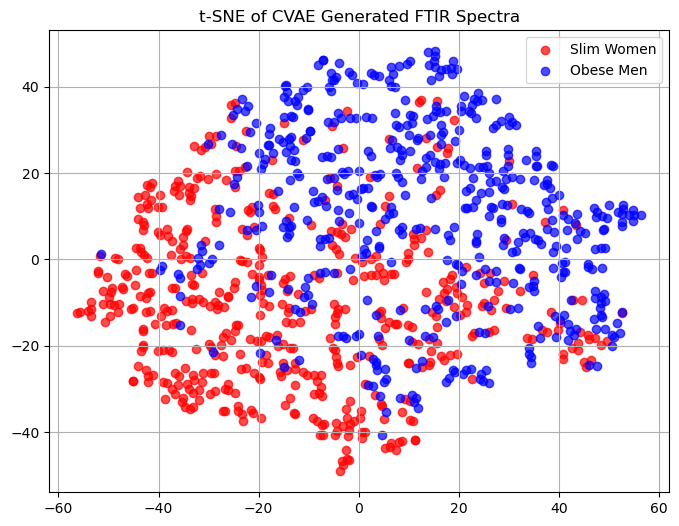

In [23]:
all_spectra_cvae = np.vstack([spectra_a_cvae, spectra_b_cvae])
labels_cvae = ["Obese Men"] * N + ["Slim Women"] * N

# t-SNE
tsne_cvae = TSNE(n_components=2, perplexity=15, random_state=42)
embeddings_cvae = tsne_cvae.fit_transform(all_spectra_cvae)

# Plot
plt.figure(figsize=(8, 6))
colors_cvae = {"Obese Men": "blue", "Slim Women": "red"}
for label in set(labels_cvae):
    idxs = [i for i, l in enumerate(labels_cvae) if l == label]
    plt.scatter(embeddings_cvae[idxs, 0], embeddings_cvae[idxs, 1], label=label, alpha=0.7, c=colors_cvae[label])
plt.title("t-SNE of CVAE Generated FTIR Spectra")
plt.legend()
plt.grid(True)
plt.show()